### IMPORTING LIBERARIES

In [1]:
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import math
import os
import time
import spacy
import random
from DATASETS import ques_triples
import csv

# importing torch libraries
import torch
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn as nn
import torch.optim as optim
import torchtext as tt
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy import data
from torchtext.data.utils import get_tokenizer
from collections import Counter
import io
from torchtext.vocab import Vocab

In [2]:
# Change the file direc.
# RUN
with open('C:/Users/Praty/OneDrive/Desktop/lcq2_MT_train.json') as file:
    question_triples_train = json.load(file)
question_to_triple_df = pd.read_json('C:/Users/Praty/OneDrive/Desktop/lcq2_MT_train.json')

In [3]:
# reading directly from file
question_triples_train
# reading into pandas dataframe
question_to_triple_df.head()

,uid,question,sparql_wikidata,template_id,question_pos,ent_masked_ques,question_with_pos,triples_template
0,19719,What periodical literature does Delta Air Line...,select distinct ?obj where { wd:Q188920 wdt:P...,5,WP JJ NN VBZ NNP NNP NNPS NN IN DT NN,what [Entity1] does [Entity2] use as a moutpiece?,What/WP periodical/JJ literature/NN does/VBZ D...,[ delta air lines ] < house publication > obje...
1,15554,Who is the child of Ranavalona I's husband?,SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X ....,18,WP VBZ DT NN IN NNP PRP POS NN,who is the child of [Entity1]'s husband?,Who/WP is/VBZ the/DT child/NN of/IN Ranavalona...,[ ranavalona i of madagascar ] < spouse > ?x ....
2,974,Is it true Jeff_Bridges occupation Lane Chandl...,ASK WHERE { wd:Q174843 wdt:P106 wd:Q1804811 . ...,17,VBZ PRP JJ NNP NN NNP NNP CC RB,is it true [Entity1] occupation [Entity2] and ...,Is/VBZ it/PRP true/JJ Jeff_Bridges/NNP occupat...,[ jeff bridges ] < occupation > [ lane chandle...
3,15803,What is the pre-requisite of phase matter of G...,SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...,23,WP VBZ DT NN IN NN NN IN NNP,what is the pre-requisite of phase matter of [...,What/WP is/VBZ the/DT pre-requisite/NN of/IN p...,[ galinstan ] < phase of matter > ?x . ?x < fo...
4,27610,Which is the operating income for Qantas?,select distinct ?answer where { wd:Q32491 wdt:...,22,WDT VBZ DT NN NN IN NNP,which is the operating income for [Entity1]?,Which/WDT is/VBZ the/DT operating/NN income/NN...,[ qantas ] < operating income > answer


In [4]:
df_train_question = question_to_triple_df[["question","triples_template"]]

### HARD CODE PREPROCESSING 
##### DO NOT RUN

In [5]:
# Do NOT RUN
# DATA PREPROCESSING FIRST STEP AND READING
# adding <sos> and <eos> before and ending of each sentence
start_of_sentence = "<sos> "
end_of_sentence = " <eos>"

for i in range(len(df_train_question['question'])):
    df_train_question['question'][i] = start_of_sentence + df_train_question['question'][i]+ end_of_sentence
for i in range(len(df_train_question['triples_template'])):
    df_train_question['triples_template'][i] = start_of_sentence + df_train_question['triples_template'][i]+ end_of_sentence


C:\Users\Praty\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# testing 
# DO NOT RUN
print(df_train_question['question'][0])
print(df_train_question['triples_template'][0])

<sos> What periodical literature does Delta Air Lines use as a moutpiece? <eos>
<sos> [ delta air lines ] < house publication > object . object < instance of > [ periodical ] <eos>


In [7]:
# REGEX OPERATION
# DON NOT RUN
import re
#print(df_train_question['triples_template'][6])
for i in range(len(df_train_question['triples_template'])):
    df_train_question['triples_template'][i] = re.sub(r'(\s([,!"]))|(?<=\[|\()(.*?)(?=\)|\])|(?<=\<|\()(.*?)(?=\)|\>)', lambda x: x.group().strip(), df_train_question['triples_template'][i])

In [8]:
# testing
# DO NOT RUN
print(df_train_question['triples_template'][0])

<sos> [delta air lines] <house publication> object . object <instance of> [periodical] <eos>


In [9]:
# DO NOT RUN
# Dividing the questions and triples_template into two files
# warning and error extra index forms everytime when load have to delete it manualy from csv files
# creating file for questions
df_train_question['question'].to_csv("C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/ques_trip_data_1.csv")
# creating files for triples
df_train_question['triples_template'].to_csv("C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/ques_trip_data_2.csv")

C:\Users\Praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Praty\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [10]:
# DO NOT RUN
# storing the data from csv to txt files for easy parsing
# triples csv to txt [ques_trip_data_2 to triples_en]
with open('C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/triples_en.txt', "w",encoding="mbcs") as my_output_file:
    with open('C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/ques_trip_data_2.csv', "r",encoding="mbcs") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

# question csv to txt [ques_trip_data_1 to questions_en]
with open('C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/questions_en.txt', "w",encoding="mbcs") as my_output_file:
    with open('C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/ques_trip_data_1.csv', "r",encoding="mbcs") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()  

In [11]:
# DO NOT RUN
# GENERATING  train, test, validation sets INDICES
def generate_indices(data_len):
    indices = [i for i in range(data_len)]
    random.shuffle(indices)
    
    # 80:20:0 splitting the train, validation, test set.
    train_idx = int(data_len*0.8)
    val_idx = train_idx + int(data_len*0.2)
    
    return indices[:train_idx], indices[train_idx : val_idx], indices[val_idx:]
                                                            
train_indices, val_indices, test_indices = generate_indices(len(df_train_question))                                                            

In [12]:
# DO NOT RUN
# preprocess of QUESTION DATASET
file_path = ['C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/questions_en.txt','C:/Users/Praty/OneDrive/Desktop/ques_triple_sets/triples_en.txt']
# storing the data into list
data = []
data_1 = []
with open(file_path[0],encoding="mbcs") as fp:
    for line in fp:
        data.append(line.strip())
with open(file_path[1],encoding="mbcs") as fp:
    for line in fp:
        data_1.append(line.strip())

In [13]:
# DO NOT RUN
# testing
print(data[0])
print("total question ",len(data))
print(data_1[0])
print("total_triples ",len(data_1))

<sos> What periodical literature does Delta Air Lines use as a moutpiece? <eos>
total question  23895
<sos> [delta air lines] <house publication> object . object <instance of> [periodical] <eos>
total_triples  23886


### Processing of Questions

In [17]:
# first for question_en processing
# DO NOT RUN
lang = 'en_core_web_sm'
lang_model = spacy.load(lang,  disable=['tagger','parser','ner'])

punctuation = ['(', ')', ':', '"', ' ','<','>']
def process_sen(lang_model, sentence, punctuation):
    sentence = sentence.lower()
    sentence = [tok.text for tok in lang_model.tokenizer(sentence) if tok.text not in punctuation]
    return sentence

processed_sentence = [process_sen(lang_model, sentence, punctuation) for sentence in data]

In [18]:
# testing
# DO NOT RUN
processed_sentence

[['sos',
  'what',
  'periodical',
  'literature',
  'does',
  'delta',
  'air',
  'lines',
  'use',
  'as',
  'a',
  'moutpiece',
  '?',
  'eos'],
 ['sos',
  'who',
  'is',
  'the',
  'child',
  'of',
  'ranavalona',
  'i',
  "'s",
  'husband',
  '?',
  'eos'],
 ['sos',
  'is',
  'it',
  'true',
  'jeff_bridges',
  'occupation',
  'lane',
  'chandler',
  'and',
  'photographer',
  '?',
  'eos'],
 ['sos',
  'what',
  'is',
  'the',
  'pre',
  '-',
  'requisite',
  'of',
  'phase',
  'matter',
  'of',
  'galinstan',
  '?',
  'eos'],
 ['sos',
  'which',
  'is',
  'the',
  'operating',
  'income',
  'for',
  'qantas',
  '?',
  'eos'],
 ['sos', 'which', 'cola', 'starts', 'with', 'the', 'letter', 'p', 'eos'],
 ['sos',
  'is',
  'the',
  'right',
  'ascension',
  'of',
  'malin',
  '1',
  'less',
  'than',
  '15.1398',
  '?',
  'eos'],
 ['sos',
  'what',
  'is',
  'the',
  'complete',
  'list',
  'of',
  'records',
  'released',
  'by',
  'jerry',
  'lee',
  'lewis',
  '?',
  'eos'],
 ['sos'

In [19]:
len(processed_sentence)

23895

In [20]:
train = [processed_sentence[i] for i in train_indices]

In [21]:
# testing
train[0]

['sos',
 'how',
 'many',
 'bodies',
 'of',
 'water',
 'are',
 'located',
 'in',
 'or',
 'next',
 'to',
 'the',
 'aegean',
 'sea',
 '?',
 'eos']

In [33]:
# building vocabulary
# DO NOT RUN
freq_list = Counter()
for sentence in train:
    freq_list.update(sentence)
#en_vocab = Vocab(freq_list, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
freq_list = freq_list.most_common(10000)

In [91]:
# testing
freq_list
print(len(freq_list))

10003


In [35]:
# reserving the indexes for the 
# DO NOT RUN
freq_list = {freq[0]:i+1 for i, freq in enumerate(freq_list)}
freq_list['[pad]'] = 0
#freq_list['[OOV]'] = 1
freq_list['[sos]'] = 1
freq_list['[eos]'] = 2

def map_words(sentence, freq_list):
    return [freq_list[word] for word in sentence if word in freq_list]


processed_sentences = [map_words(sentence, freq_list) for sentence in processed_sentence]

#en_tensor = torch.tensor([en_vocab[token] for token in train], dtype = torch.lang)



In [36]:
# testing
processed_sentences

[[1, 7, 5991, 455, 41, 1378, 388, 1486, 314, 32, 18, 4, 2],
 [1, 11, 6, 3, 91, 5, 27, 25, 876, 4, 2],
 [1, 6, 33, 73, 362, 13, 3269, 4, 2],
 [1, 7, 6, 3, 8386, 19, 5, 854, 956, 5, 7714, 4, 2],
 [1, 8, 6, 3, 304, 871, 10, 1971, 4, 2],
 [1, 8, 1158, 44, 17, 3, 35, 372, 2],
 [1, 6, 3, 1701, 3993, 5, 60, 99, 58, 4, 2],
 [1, 7, 6, 3, 1379, 357, 5, 584, 1513, 26, 1273, 707, 977, 4, 2],
 [1, 7, 25, 563, 2312, 5280, 25, 144, 578, 904, 555, 27, 1559, 2],
 [1, 11, 456, 3, 100, 43, 3, 1556, 5, 3, 4108, 25, 5441, 4, 2],
 [1, 6, 33, 73, 15, 3, 706, 3161, 5, 3, 6120, 459, 818, 6, 4, 2],
 [1,
  39,
  36,
  3,
  583,
  1802,
  5023,
  15,
  1197,
  9,
  637,
  689,
  13,
  54,
  3,
  38,
  212,
  9,
  33,
  25,
  20,
  4,
  2],
 [1,
  14,
  6172,
  4617,
  945,
  9,
  3,
  3678,
  4446,
  136,
  4470,
  2584,
  9,
  1967,
  13,
  5206,
  4,
  2],
 [1, 22, 50, 14, 1300, 2245, 120, 42, 1551, 426, 21, 1468, 4, 2],
 [1, 42, 70, 19, 70, 19, 1017, 21, 7, 6, 3, 5, 4, 2],
 [1, 7, 2125, 811, 6, 2279, 24, 567, 

In [37]:
train_ques_new = [processed_sentences[i] for i in train_indices]
val_ques_new = [processed_sentences[i] for i in val_indices]
test_ques_new = [processed_sentences[i] for i in test_indices]

In [38]:
train_ques_new

[[1, 28, 30, 1246, 5, 210, 23, 68, 9, 77, 289, 24, 3, 9337, 404, 4, 2],
 [1, 7, 1343, 6, 3, 1166, 5, 9338, 167, 4, 2],
 [1, 8, 170, 12, 250, 4618, 27, 84, 9, 21, 8, 3, 1705, 92, 348, 6, 9339, 4, 2],
 [1,
  7,
  6,
  9340,
  2707,
  17,
  3,
  129,
  51,
  5,
  3714,
  37,
  380,
  5,
  6,
  4619,
  2707,
  4,
  2],
 [1, 11, 14, 6174, 6175, 110, 10, 9, 1572, 4, 2],
 [1, 7, 6, 3, 111, 17, 3, 490, 954, 536, 37, 380, 5, 6, 111, 4, 2],
 [1, 6, 33, 73, 15, 3, 2095, 92, 5, 1573, 6, 99, 58, 9341, 4, 2],
 [1, 7, 6, 3, 9342, 761, 27, 29, 10, 18, 6176, 4, 2],
 [1, 40, 6, 3, 1876, 68, 4620, 13, 9, 3, 111, 4, 2],
 [1, 8, 6, 3, 9343, 87, 27, 29, 10, 9344, 5, 3, 3120, 5, 3, 1574, 4, 2],
 [1, 7, 50, 14, 250, 459, 5, 185, 120, 446, 42, 9345, 4, 2],
 [1, 11, 447, 794, 9346, 4, 2],
 [1, 7, 23, 3, 430, 5, 903, 15, 54, 3, 38, 9347, 9, 104, 20, 2],
 [1, 22, 14, 2708, 4621, 173, 3121, 391, 6177, 9, 131, 1575, 4, 2],
 [1, 8, 111, 2096, 4622, 2369, 4, 2],
 [1, 7, 6, 9348, 27, 29, 10, 4623, 4624, 4, 2],
 [1, 7,

### Procecessing of triplets

In [39]:
# for triples_template
# DO NOT RUN
lang = 'en_core_web_sm'
lang_model = spacy.load(lang,  disable=['tagger','parser','ner'])
#punctuation = ['(', ')', ':', '"', ' ']
def process_sen1(sentence):
    sentence = sentence.lower()
    sentence = [tok for tok in sentence.split(" ")]
    return sentence

processed_sen = [process_sen1(sentence) for sentence in data_1]

In [40]:
processed_sen

[['<sos>',
  '[delta',
  'air',
  'lines]',
  '<house',
  'publication>',
  'object',
  '.',
  'object',
  '<instance',
  'of>',
  '[periodical]',
  '<eos>'],
 ['<sos>',
  '[ranavalona',
  'i',
  'of',
  'madagascar]',
  '<spouse>',
  '?x',
  '.',
  '?x',
  '<father>',
  'answer',
  '<eos>'],
 ['<sos>',
  '[jeff',
  'bridges]',
  '<occupation>',
  '[lane',
  'chandler]',
  '.',
  '[jeff',
  'bridges]',
  '<occupation>',
  '[photographer]',
  '<eos>'],
 ['<sos>',
  '[galinstan]',
  '<phase',
  'of',
  'matter>',
  '?x',
  '.',
  '?x',
  '<followed',
  'by>',
  'answer',
  '<eos>'],
 ['<sos>', '[qantas]', '<operating', 'income>', 'answer', '<eos>'],
 ['<sos>',
  'subject',
  '<instance',
  'of>',
  '[cola]',
  '.',
  'subject',
  'rdfs:label',
  'subject_label',
  '.',
  'filter(strstarts(lcase(subject_label),',
  "'p'))",
  '.',
  'filter',
  '(lang(subject_label)',
  '=',
  "'en')",
  '',
  'limit',
  '25',
  '<eos>'],
 ['<sos>',
  '[malin',
  '1]',
  '<right',
  'ascension>',
  'objec

In [41]:
train_1 = [processed_sen[i] for i in train_indices]

In [46]:
# DO NOT RUN
freq_list_1 = Counter()
for sentence in train_1:
    freq_list_1.update(sentence)
#en_vocab = Vocab(freq_list, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
freq_list_1 = freq_list_1.most_common(10000)

In [92]:
len(freq_list_1)

10003

In [48]:
# DO NOT RUN
freq_list_1 = {freq[0]:i for i, freq in enumerate(freq_list_1)}
freq_list_1['[PAD]'] = 0
#freq_list_1['[OOV]'] = 1
freq_list_1['[sos]'] = 1
freq_list_1['[eos]'] = 2

def map_words(sentence, freq_list_1):
    return [freq_list_1[word] for word in sentence if word in freq_list_1]


processed_sentences_triples = [map_words(sentence, freq_list_1) for sentence in processed_sen]



In [49]:
processed_sentences_triples

[[1, 1726, 961, 1925, 1972, 565, 5, 0, 5, 10, 9, 4712, 2],
 [1, 147, 6, 45, 7, 0, 7, 201, 4, 2],
 [1, 1590, 8733, 93, 0, 1590, 8733, 93, 2],
 [1, 9494, 423, 6, 1379, 7, 0, 7, 99, 30, 4, 2],
 [1, 2214, 376, 680, 4, 2],
 [1,
  8,
  10,
  9,
  4452,
  0,
  8,
  18,
  19,
  0,
  41,
  410,
  0,
  20,
  21,
  13,
  22,
  11,
  17,
  23,
  2],
 [1, 842, 5, 29, 102, 2],
 [1, 942, 6488, 1368, 1418, 5, 0, 5, 10, 9, 3709, 2],
 [1, 536, 4316, 4317, 387, 31, 4, 2],
 [1, 3562, 435, 8164, 99, 30, 7, 0, 7, 114, 4, 2],
 [1, 6540, 3380, 5, 29, 13, 2],
 [1,
  8,
  10,
  9,
  1544,
  4689,
  6232,
  0,
  8,
  376,
  554,
  924,
  0,
  8,
  18,
  19,
  0,
  40,
  0,
  20,
  21,
  13,
  22,
  11,
  17,
  23,
  2],
 [1,
  4467,
  3584,
  162,
  82,
  6645,
  373,
  6562,
  3562,
  0,
  4467,
  3584,
  162,
  82,
  6645,
  373,
  6562,
  3562,
  2],
 [1, 1020, 2403, 28, 27, 3, 0, 3, 28, 27, 5, 0, 3, 43, 14, 7, 1182, 2],
 [1, 51, 3, 0, 3, 51, 5, 0, 3, 32, 15, 14, 7, 1122, 2],
 [1, 8, 221, 353, 354, 2288, 0, 8

In [50]:
# DO NOT RUN
train_triple_new = [processed_sentences_triples[i] for i in train_indices]
val_triple_new = [processed_sentences_triples[i] for i in val_indices]
test_triple_new = [processed_sentences_triples[i] for i in test_indices]

In [51]:
train_triple_new

[[1, 4, 6652, 953, 4840, 3797, 2],
 [1, 518, 333, 539, 63, 0, 518, 333, 178, 64, 2],
 [1,
  8,
  10,
  9,
  1889,
  399,
  0,
  8,
  174,
  132,
  677,
  0,
  8,
  18,
  19,
  0,
  41,
  750,
  0,
  20,
  21,
  13,
  22,
  11,
  17,
  23,
  2],
 [1, 150, 7, 0, 7, 493, 4, 2],
 [1, 653, 2175, 15, 6653, 6654, 6655, 233, 7, 0, 7, 631, 4, 2],
 [1, 4841, 2176, 2177, 3, 0, 3, 2176, 2177, 7, 0, 3, 6656, 6657, 246, 12, 2],
 [1, 4842, 2551, 126, 5, 29, 102, 2],
 [1, 8, 80, 210, 0, 8, 10, 9, 370, 2],
 [1,
  8,
  10,
  9,
  4843,
  0,
  8,
  175,
  2552,
  2178,
  0,
  8,
  18,
  19,
  0,
  41,
  410,
  0,
  20,
  21,
  13,
  22,
  11,
  17,
  23,
  2],
 [1, 269, 156, 270, 7, 0, 7, 1257, 196, 4, 2],
 [1, 281, 3089, 6, 211, 28, 27, 3, 0, 3, 28, 27, 5, 0, 3, 43, 14, 7, 2],
 [1, 8, 325, 196, 1890, 1077, 1078, 0, 8, 10, 9, 1536, 330, 2],
 [1,
  8,
  10,
  9,
  602,
  6,
  1079,
  0,
  8,
  18,
  19,
  0,
  40,
  0,
  20,
  21,
  13,
  22,
  11,
  17,
  23,
  2],
 [1, 36, 74, 35, 12, 37, 11, 2553, 2554

In [74]:
# DO NOT RUN
# padding the sentences to make it equal
from torch.nn.utils.rnn import pad_sequence


# FOR TRAIN_QUES_NEW
x_ques = len(train_ques_new[0])
for i in range(len(train_ques_new)):
    if(x_ques >= len(train_ques_new[i])):
        continue
    else:
        x_ques = len(train_ques_new[i])
print(x_ques)
        
for i in range(len(train_ques_new)):
    diff = x_ques - len(train_ques_new[i])
    for j in range(diff):
        train_ques_new[i].append(0)

# FOR VAL_QUES_NEW
y_ques = len(val_ques_new[0])
for i in range(len(val_ques_new)):
    if(y_ques >= len(val_ques_new[i])):
        continue
    else:
        y_ques = len(val_ques_new[i])
print(y_ques)
        
for i in range(len(val_ques_new)):
    diff = y_ques - len(val_ques_new[i])
    for j in range(diff):
        val_ques_new[i].append(0)
        
# FOR TEST_QUES_NEW

# FOR TRAIN_QUES_NEW
z_ques = len(test_ques_new[0])
for i in range(len(test_ques_new)):
    if(z_ques >= len(test_ques_new[i])):
        continue
    else:
        z_ques = len(test_ques_new[i])
print(z_ques)
        
for i in range(len(test_ques_new)):
    diff = z_ques - len(test_ques_new[i])
    for j in range(diff):
        test_ques_new[i].append(0)

# For TRAIN_tRIPLE_NEW
x1_ques = len(train_triple_new[0])
for i in range(len(train_triple_new)):
    if(x1_ques >= len(train_triple_new[i])):
        continue
    else:
        x1_ques = len(train_triple_new[i])
print(x1_ques)
        
for i in range(len(train_triple_new)):
    diff = x1_ques - len(train_triple_new[i])
    for j in range(diff):
        train_triple_new[i].append(0)

# for val_triple_new
y1_ques = len(val_triple_new[0])
for i in range(len(val_triple_new)):
    if(y1_ques >= len(val_triple_new[i])):
        continue
    else:
        y1_ques = len(val_triple_new[i])
print(y1_ques)
        
for i in range(len(val_triple_new)):
    diff = y1_ques - len(val_triple_new[i])
    for j in range(diff):
        val_triple_new[i].append(0)
    
# test triple ques    
z1_ques = len(test_triple_new[0])
for i in range(len(test_triple_new)):
    if(z1_ques >= len(test_triple_new[i])):
        continue
    else:
        z1_ques = len(test_triple_new[i])
print(z1_ques)
        
for i in range(len(test_triple_new)):
    diff = z1_ques - len(test_triple_new[i])
    for j in range(diff):
        test_triple_new[i].append(0)

38
37
18
43
42
11


In [76]:
(val_triple_new[0])

[1,
 8,
 10,
 9,
 401,
 6,
 0,
 8,
 18,
 19,
 0,
 40,
 0,
 20,
 21,
 13,
 22,
 11,
 17,
 23,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [77]:
# appending the data together
# DO NOT RUN
train_data = []
val_data  = []
test_data = []
for i in range(len(train_ques_new)):
    train_data.append((train_ques_new[i], train_triple_new[i]))
for i in range(len(val_ques_new)):
    val_data.append((val_ques_new[i] , val_triple_new[i]))
for i in range(len(test_ques_new)):
    test_data.append((test_ques_new[i], test_triple_new[i]))


In [78]:
# TESTING
train_data

[([1,
   28,
   30,
   1246,
   5,
   210,
   23,
   68,
   9,
   77,
   289,
   24,
   3,
   9337,
   404,
   4,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [1,
   4,
   6652,
   953,
   4840,
   3797,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0]),
 ([1,
   7,
   1343,
   6,
   3,
   1166,
   5,
   9338,
   167,
   4,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  [1,
   518,
   333,
   539,
   63,
   0,
   518,
   333,
   178,
   64,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,


In [83]:
# GENERATING BATCHEs
# DO NOT RUN
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
train_itr = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle= True)
valid_itr = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle= True)
test_itr = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle= True)

In [88]:
# DO NOT RUN
len(train_itr) #150
len(valid_itr) #38
len(test_itr)  #1

1

# START FROM HERE
### PART 1. PREPROCESSING THE DATA

In [513]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator


lang = 'en_core_web_sm'
lang_model = spacy.load(lang,  disable=['tagger','parser','ner'])

def process_sen(text):
    return [tok.text for tok in lang_model.tokenizer(text)]

def process_sentence(text):
    return [tok for tok in text.split(" ")]

SRC = Field( 
            tokenize = process_sen,
            init_token ='<sos>', 
            eos_token ='<eos>',
            lower = True,
           batch_first = True)

TRG = Field(
           tokenize = process_sentence,
           init_token ='<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)
fields = {'SRC': ('src', SRC), 'TRG': ('trg',TRG)}



In [514]:
# dividing the train, val, test data.
# change path before running.
train_data_1, val_data_1, test_data_1 = TabularDataset.splits(path ='C:/Users/Praty/OneDrive/Desktop/ques_triple_sets',
                                                       train='train_ques.csv',
                                                       validation = 'val_ques.csv',
                                                       test = 'test_final.csv',
                                                       format = 'csv',
                                                       fields = fields,
                                                       skip_header = False)

In [ ]:
print(len(test_data_1))
print(len(train_data_1))
print(len(val_data_1))

In [516]:
# Building the vocab
SRC.build_vocab(train_data_1,
               max_size = 10000,
               min_freq = 2)
TRG.build_vocab(train_data_1,
               max_size = 10000,
               min_freq = 2)

In [517]:
# Using BucketIterator for distributing the data into train, test, val iterations
train_iter, val_iter, test_iter = BucketIterator.splits((train_data_1,
                                                        val_data_1,
                                                        test_data_1),
                                                       batch_size = 128,
                                                        sort = False,
                                                       device=device)

### PART 2. MODEL IMPLEMENTATION 
#### ENCODER LAYER

In [481]:
class Encoder(nn.Module):
    def __init__(self,
                input_dim,
                hid_dim,
                n_layers,
                n_heads,
                pf_dim,
                dropout,
                device,
                max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                 n_heads,
                                                 pf_dim,
                                                 dropout,
                                                 device)
                                    for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    
    def forward(self, src, src_mask):
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embedding(src)* self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

In [482]:
class EncoderLayer(nn.Module):
    def __init__(self,
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.postionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,pf_dim,dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask):
        
        _src, _ = self.self_attention(src, src, src, src_mask) 
        
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src

#### ATTENTION LAYER

In [483]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask=None):
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        
        
        energy =torch.matmul(Q, K.permute(0,1,3,2))/self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        
        x = torch.matmul(self.dropout(attention),V)
        
        x = x.permute(0,2,1,3).contiguous()
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        x = self.fc_o(x)
        
        return x, attention

#### POSITION ENCODING

In [484]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        x = self.fc_2(x)
        
        return x

#### DECODER LAYER

In [485]:
class Decoder(nn.Module):
    def __init__(self,
                output_dim,
                hid_dim,
                n_layers,
                n_heads,
                pf_dim,
                dropout,
                device,
                max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                n_heads,
                                                pf_dim,
                                                dropout,
                                                device)
                                   for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        output = self.fc_out(trg)
        
        return output, attention

In [486]:
class DecoderLayer(nn.Module):
    def __init__(self,
                hid_dim,
                n_heads,
                pf_dim,
                dropout,
                device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

#### SEQUENCE TO SEQUENCE 

In [487]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

#### INTIALIZING ALL THE DIMESIONS

In [488]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [489]:
PAD_IDX_QUES = SRC.vocab.stoi[SRC.pad_token]
PAD_IDX_TRIP = TRG.vocab.stoi[TRG.pad_token]
model = Seq2Seq(enc, dec,PAD_IDX_QUES, PAD_IDX_TRIP ,device).to(device)

In [490]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,913,646 trainable parameters


#### INTIALIZING RANDOM WEIGHTS

In [491]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [492]:
model.apply(initialize_weights);

In [493]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [494]:
# think about it
criterion = nn.CrossEntropyLoss(ignore_index= PAD_IDX_TRIP)

#### TRAINING THE MODEL

In [495]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        #print(src)
        
        #print(trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

#### EVALUATION OF THE MODEL

In [496]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [497]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [498]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 6m 37s
	Train Loss: 3.309 | Train PPL:  27.346
	 Val. Loss: 1.580 |  Val. PPL:   4.856
Epoch: 02 | Time: 6m 50s
	Train Loss: 1.503 | Train PPL:   4.497
	 Val. Loss: 1.242 |  Val. PPL:   3.463
Epoch: 03 | Time: 6m 59s
	Train Loss: 1.186 | Train PPL:   3.275
	 Val. Loss: 1.070 |  Val. PPL:   2.915
Epoch: 04 | Time: 7m 4s
	Train Loss: 0.961 | Train PPL:   2.614
	 Val. Loss: 0.957 |  Val. PPL:   2.604
Epoch: 05 | Time: 7m 6s
	Train Loss: 0.779 | Train PPL:   2.180
	 Val. Loss: 0.875 |  Val. PPL:   2.399
Epoch: 06 | Time: 7m 11s
	Train Loss: 0.629 | Train PPL:   1.876
	 Val. Loss: 0.804 |  Val. PPL:   2.235
Epoch: 07 | Time: 7m 11s
	Train Loss: 0.502 | Train PPL:   1.652
	 Val. Loss: 0.758 |  Val. PPL:   2.135
Epoch: 08 | Time: 7m 12s
	Train Loss: 0.398 | Train PPL:   1.488
	 Val. Loss: 0.727 |  Val. PPL:   2.070
Epoch: 09 | Time: 7m 15s
	Train Loss: 0.310 | Train PPL:   1.364
	 Val. Loss: 0.708 |  Val. PPL:   2.030
Epoch: 10 | Time: 7m 37s
	Train Loss: 0.246 | Train PPL: 

In [499]:
# Calculating the test loss and test perplexity.
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.680 | Test PPL:   1.975 |


In [559]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):
    
    model.eval()
        
    if isinstance(sentence, str):
        #nlp = spacy.load('en_core_web_sm')
        
        tokens = [token.text.lower() for token in sentence.split(" ")]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [549]:

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [550]:

example_idx = 9

src = vars(train_data_1.examples[example_idx])['src']
trg = vars(train_data_1.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')


src = ['what', 'was', 'faroe', 'island', "'s", 'population', 'in', '2004', '?']
trg = ['[', 'faroe', 'islands', ']', '<', 'population', '>', '?', 's', '.', '?', 's', '<', 'population', '>', 'object', '.', '?', 's', '<', 'point', 'in', 'time', '>', '?', 'x', "filter(contains(year(?x),'2004", "'", ')', ')']


In [551]:

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['[', '<unk>', 'island', ']', '<', 'population', '>', '?', 's', '.', '?', 's', '<', 'population', '>', 'object', '.', '?', 's', '<', 'point', 'in', 'time', '>', '?', 'x', "filter(contains(year(?x),'2004", "'", ')', ')', '<eos>']


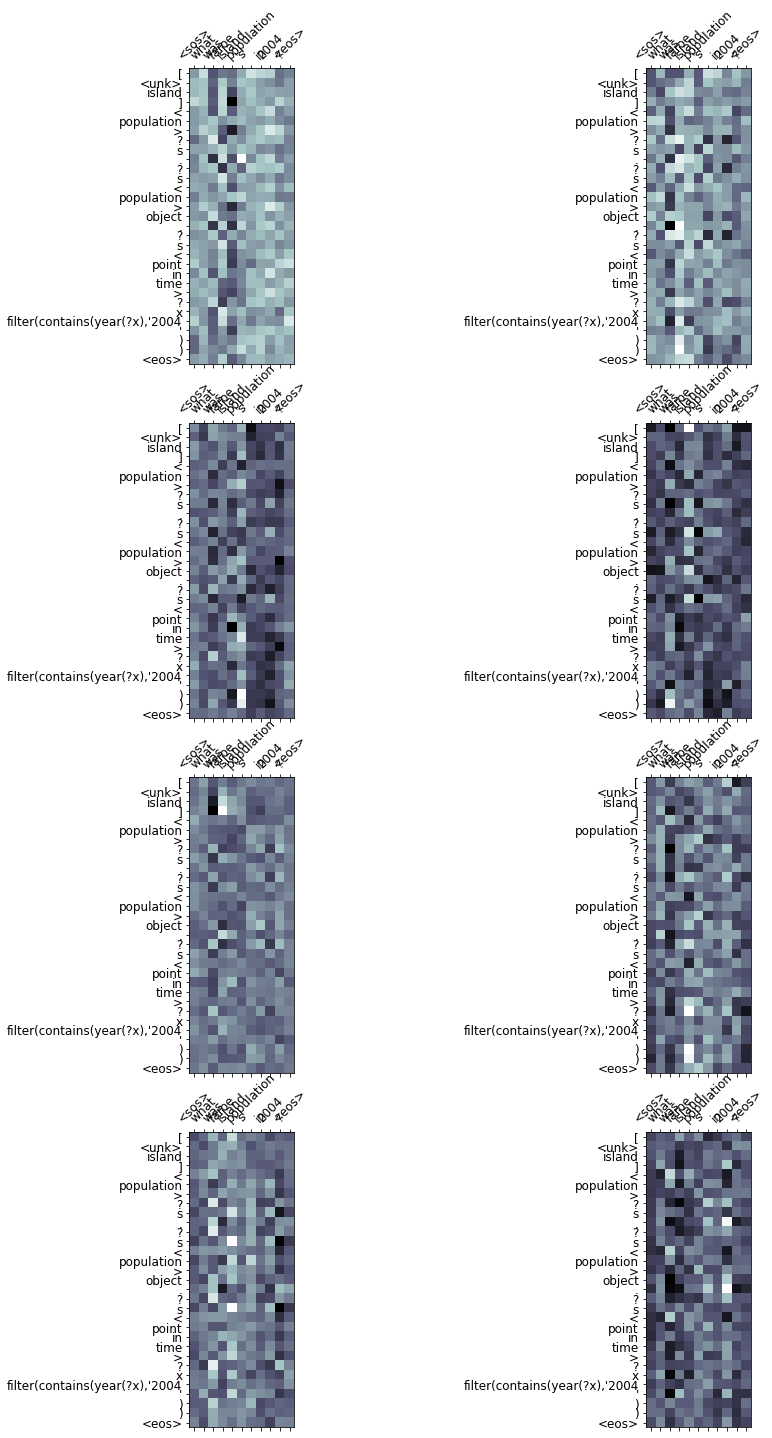

In [552]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
display_attention(src, translation, attention)

In [553]:
example_idx = 6

src = vars(val_data_1.examples[example_idx])['src']
trg = vars(val_data_1.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['in', 'the', '68th', 'academy', 'awards', ',', 'what', 'nomination', 'did', 'mira', 'sorvino', 'receive', '?']
trg = ['[', 'mira', 'sorvino', ']', '<', 'nominated', 'for', '>', '?', 's', '.', '?', 's', '<', 'nominated', 'for', '>', 'object', '.', '?', 's', '<', 'statement', 'is', 'subject', 'of', '>', '[', '68th', 'academy', 'awards', ']']


In [554]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['[', '<unk>', '<unk>', ']', '<', 'nominated', 'for', '>', '?', 's', '.', '?', 's', '<', 'nominated', 'for', '>', '[', 'academy', 'award', 'for', 'best', 'supporting', 'actress', ']', '.', '?', 's', '<', 'statement', 'is', 'subject', 'of', '>', 'value', '<eos>']


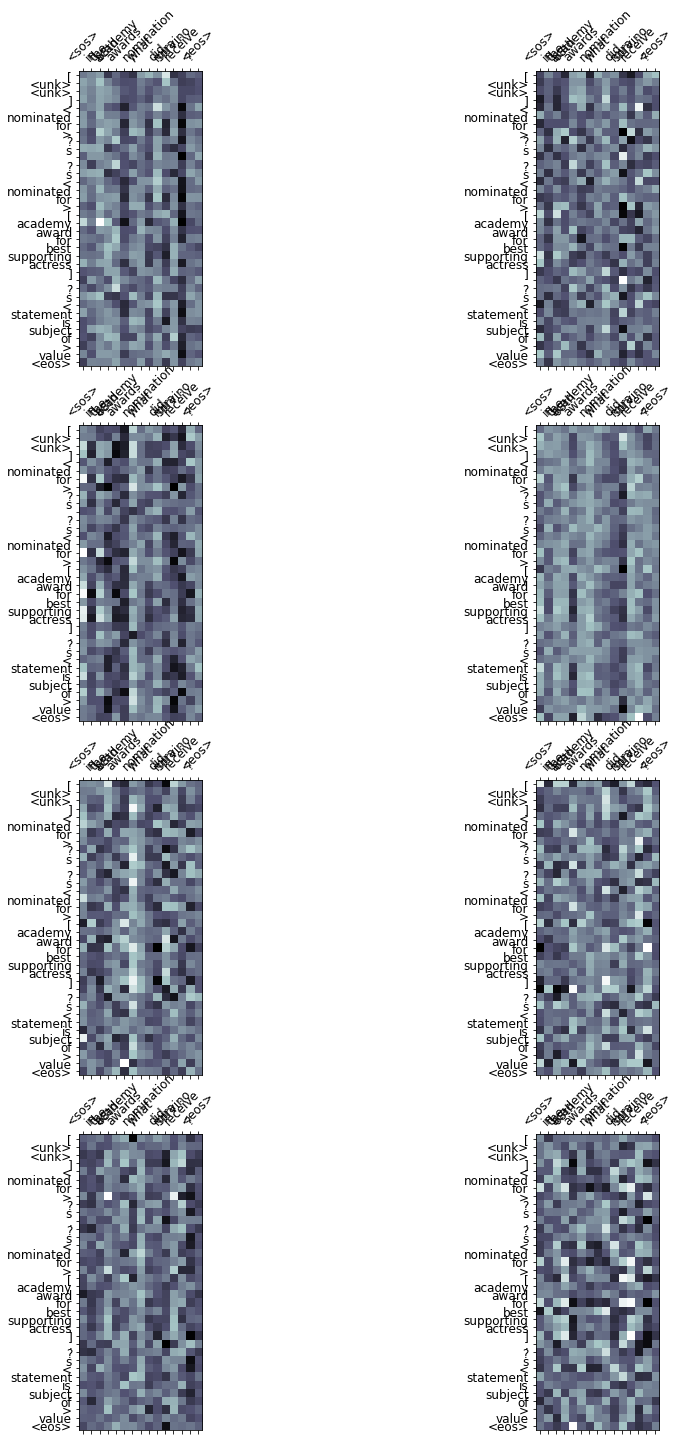

In [555]:
display_attention(src, translation, attention)

#### Calculating the Blue Score

In [580]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 101):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data_1, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')